In [29]:
import sqlite3
global  prominence,bandwidth,density_range
# 定义要查询的 symbol
symbol = "XYZ"  # 替换为你要查询的 symbol

# 连接到 SQLite 数据库
conn = sqlite3.connect("plan.db")
cursor = conn.cursor()

# 执行查询
query = """
SELECT symbol, prominence, bandwidth, density, period
FROM VP
WHERE symbol = ?
"""
cursor.execute(query, (symbol,))

# 获取查询结果
result = cursor.fetchone()

# 检查并打印结果

if result:
    prominence=result[1]
    bandwidth=result[2]
    density_range=result[3]
    period=result[4]
    print(f"Symbol: {result[0]}")
    print(f"Prominence: {result[1]}")
    print(f"Bandwidth: {result[2]}")
    print(f"Density: {result[3]}")
    print(f"Period: {result[4]}")
else:
    print(f"No record found for symbol: {symbol}")

# 关闭连接
conn.close()

Symbol: XYZ
Prominence: 0.005
Bandwidth: 0.008
Density: 0.04
Period: 3


In [30]:
def plot_kde(prices, bandwidth):
    """
    可视化核密度估计结果
    :param prices: 价格数据
    :param bandwidth: KDE的带宽参数
    """
    kde = gaussian_kde(prices, bw_method=bandwidth)
    price_range = np.linspace(min(prices), max(prices), 2000)  # 增加分辨率
    density = kde(price_range)

    plt.figure(figsize=(10, 6))
    plt.plot(price_range, density, label=f'KDE (bandwidth={bandwidth})')
    plt.title('Kernel Density Estimation of Prices')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

# 示例调用
#plot_kde(prices, bandwidth=0.001)

In [31]:
def plot_peaks(prices, bandwidth, prominence):
    """
    可视化峰值检测结果
    :param prices: 价格数据
    :param bandwidth: KDE的带宽参数
    :param prominence: 峰值的最小显著度
    """
    kde = gaussian_kde(prices, bw_method=bandwidth)
    price_range = np.linspace(min(prices), max(prices), 2000)  # 增加分辨率
    density = kde(price_range)

    # 找到所有局部峰值
    peaks, _ = find_peaks(density, height=0, prominence=prominence)

    plt.figure(figsize=(10, 6))
    plt.plot(price_range, density, label=f'KDE (bandwidth={bandwidth})')
    plt.plot(price_range[peaks], density[peaks], "x", label='Peaks')
    plt.title('Peak Detection in KDE')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

# 示例调用
#plot_peaks(prices, bandwidth=0.001, prominence=0.001)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Rhino\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


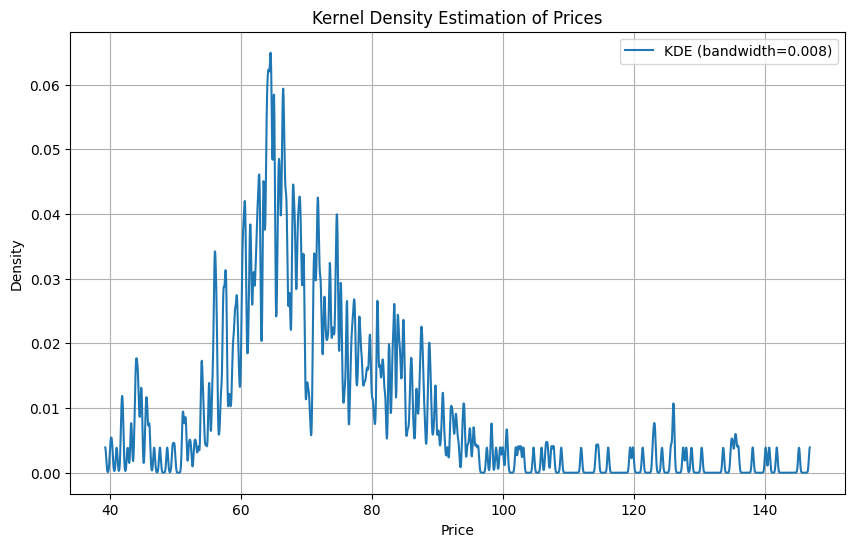

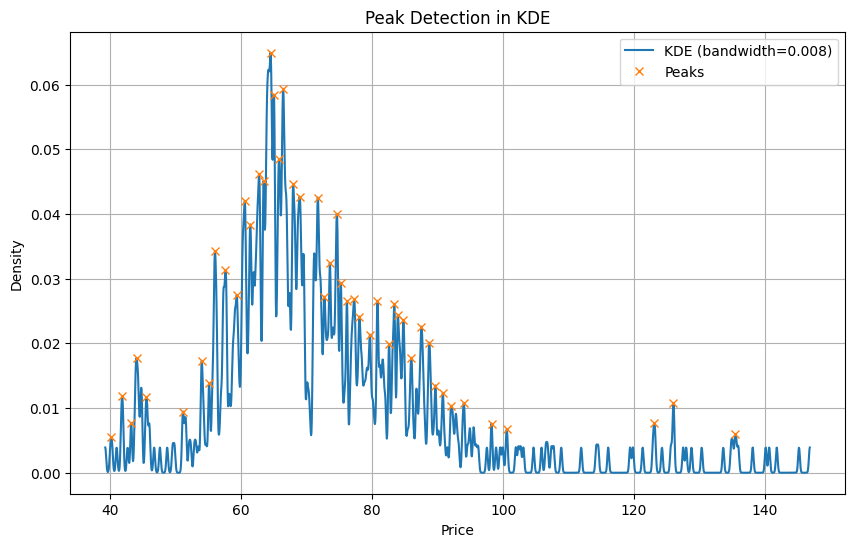

所有筹码密集区域：
中心价: 43.77, 支撑位: 42.64, 压力位: 45.45
中心价: 61.58, 支撑位: 53.85, 压力位: 67.54
中心价: 77.11, 支撑位: 74.03, 压力位: 80.17
中心价: 88.48, 支撑位: 81.46, 压力位: 94.11
中心价: 98.34, 支撑位: 94.55, 压力位: 101.93


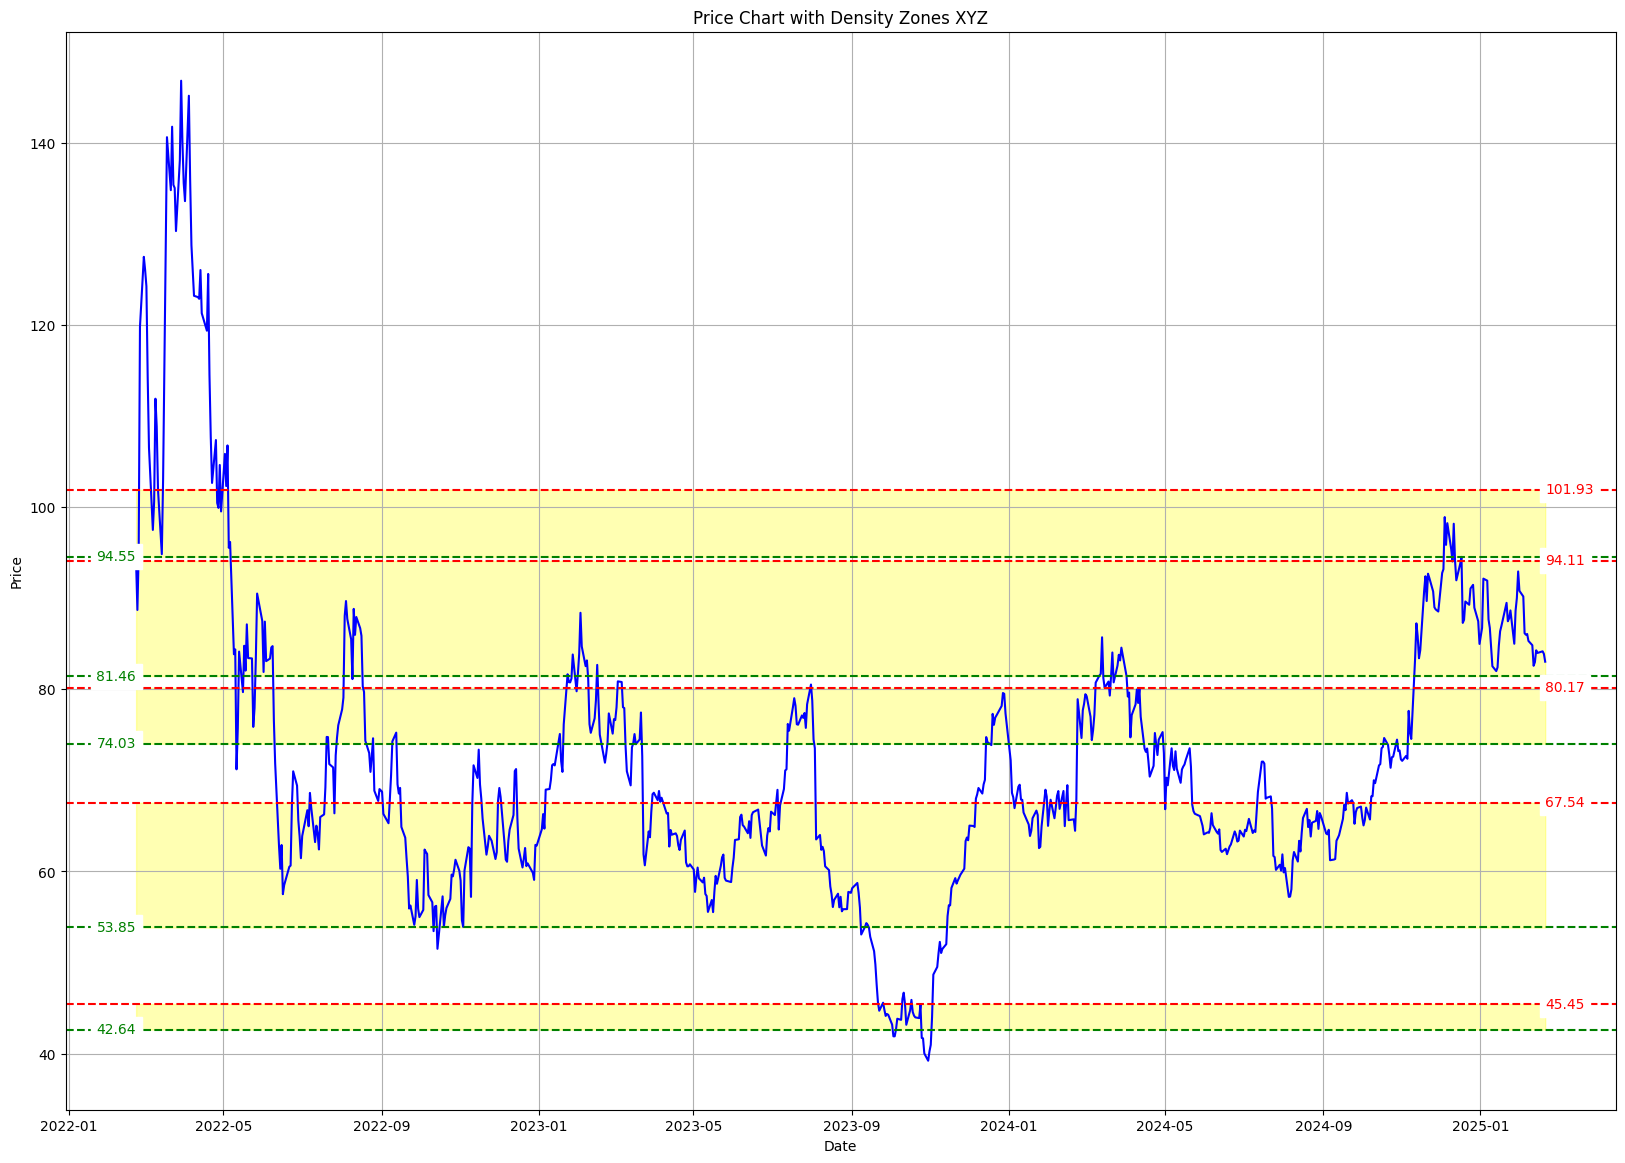

In [32]:
%pip install scipy
%run constant.ipynb
import requests
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from datetime import datetime



def get_historical_data(symbol, access_token, period_type='year', period=period, frequency_type='daily', frequency=1):
    """
    从API获取历史数据（日线级别）
    :param symbol: 股票代码
    :param access_token: API访问令牌
    :param period_type: 时间段类型（如 'year', 'month', 'day'）
    :param period: 时间段长度
    :param frequency_type: 频率类型（如 'daily', 'weekly', 'minute'）
    :param frequency: 频率值
    :return: 包含历史数据的JSON对象
    """
    base_url = 'https://api.schwabapi.com/marketdata/v1/pricehistory'
    headers = {
        'accept': 'application/json',
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'symbol': symbol,
        'periodType': period_type,
        'period': period,
        'frequencyType': frequency_type,
        'frequency': frequency,
    }

    # 发送API请求
    response = requests.get(base_url, headers=headers, params=params)

    # 检查响应状态码
    if response.status_code != 200:
        print(f"API请求失败: {response.status_code} - {response.text}")
        return None

    # 返回JSON数据
    return response.json()

def find_density_zones(prices, bandwidth=bandwidth, density_range=density_range):
    plot_kde(prices, bandwidth=bandwidth)
    plot_peaks(prices, bandwidth, prominence)
    """
    在整个历史数据中找到所有筹码密集区域
    :param prices: 价格数据
    :param bandwidth: KDE的带宽参数
    :param density_range: 密集区的范围（默认±5%）
    :return: 包含所有密集区的列表，每个密集区是一个字典，包含中心价、支撑位和压力位
    """
    # 使用核密度估计（KDE）计算价格分布
    kde = gaussian_kde(prices, bw_method=bandwidth)
    price_range = np.linspace(min(prices), max(prices), int(sum(prices)/len(prices)))
    density = kde(price_range)

    # 找到所有局部峰值（即筹码密集区的中心）
    peaks, _ = find_peaks(density, height=0, prominence=prominence)  # prominence表示峰值的最小显著度

    # 确定每个峰值对应的密集区范围
    density_zones = []
    for peak in peaks:
        center_price = price_range[peak]

        # 找到中心价附近的极限高低点
        lower_bound = center_price * (1 - density_range)
        upper_bound = center_price * (1 + density_range)

        # 在密集区内找到最低价和最高价
        zone_prices = [p for p in prices if lower_bound <= p <= upper_bound]
        if zone_prices:
            support_level = min(zone_prices)  # 支撑位：密集区内的最低价
            resistance_level = max(zone_prices)  # 压力位：密集区内的最高价
            density_zones.append({
                'center_price': center_price,
                'support': support_level,
                'resistance': resistance_level
            })

    return density_zones

def merge_density_zones(density_zones):
    """
    合并重叠的密集区
    :param density_zones: 包含所有密集区的列表
    :return: 合并后的密集区列表
    """
    # 按支撑位排序
    density_zones.sort(key=lambda x: x['support'])

    merged_zones = []
    i = 0
    while i < len(density_zones):
        current_zone = density_zones[i]
        j = i + 1
        while j < len(density_zones):
            next_zone = density_zones[j]
            # 如果当前区域的上沿超过下一个区域的下沿，则合并
            if current_zone['resistance'] >= next_zone['support']:
                current_zone['support'] = min(current_zone['support'], next_zone['support'])
                current_zone['resistance'] = max(current_zone['resistance'], next_zone['resistance'])
                current_zone['center_price'] = (current_zone['center_price'] + next_zone['center_price']) / 2
                j += 1
            else:
                break
        # 检查新的区域是否与更上方的区域重叠
        if merged_zones and current_zone['support'] <= merged_zones[-1]['resistance']:
            # 如果重叠，则合并到上一个区域
            merged_zones[-1]['support'] = min(merged_zones[-1]['support'], current_zone['support'])
            merged_zones[-1]['resistance'] = max(merged_zones[-1]['resistance'], current_zone['resistance'])
            merged_zones[-1]['center_price'] = (merged_zones[-1]['center_price'] + current_zone['center_price']) / 2
        else:
            merged_zones.append(current_zone)
        i = j

    return merged_zones

def calculate_support_resistance(data):
    """
    计算所有筹码密集区域的支撑位和压力位
    :param data: 包含历史数据的JSON对象
    :return: 包含所有密集区的列表
    """
    if not data or 'candles' not in data:
        print("未找到有效的历史数据")
        return None

    # 将数据转换为DataFrame
    df = pd.DataFrame(data['candles'])

    # 将时间戳转换为日期格式
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

    # 提取收盘价作为筹码分布的依据
    prices = df['close'].values

    # 找到所有筹码密集区域
    density_zones = find_density_zones(prices)

    # 合并重叠的密集区
    merged_zones = merge_density_zones(density_zones)

    return merged_zones, df


def plot_chart_with_zones(df, density_zones):
    """
    绘制日线图并标记筹码密集区域
    :param df: 包含历史数据的DataFrame
    :param density_zones: 筹码密集区域列表
    """
    plt.figure(figsize=(20, 14))

    # 绘制日线图
    plt.plot(df['datetime'], df['close'], label='Close Price', color='blue')

    # 标记筹码密集区域
    for zone in density_zones:
        plt.axhline(y=zone['support'], color='green', linestyle='--', label=f"Support: {zone['support']:.2f}")
        plt.axhline(y=zone['resistance'], color='red', linestyle='--', label=f"Resistance: {zone['resistance']:.2f}")
        plt.fill_between(df['datetime'], zone['support'], zone['resistance'], color='yellow', alpha=0.3)

        # 在左侧标记支撑位
        plt.text(df['datetime'].iloc[0], zone['support'], f"{zone['support']:.2f}", 
                 color='green', va='center', ha='right', backgroundcolor='white')

        # 在右侧标记压力位
        plt.text(df['datetime'].iloc[-1], zone['resistance'], f"{zone['resistance']:.2f}", 
                 color='red', va='center', ha='left', backgroundcolor='white')

    # 设置图表标题和标签
    plt.title(f'Price Chart with Density Zones {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.show()
def main(symbol, access_token):
    """
    主函数：获取数据并计算所有筹码密集区域的支撑位和压力位
    :param symbol: 股票代码
    :param access_token: API访问令牌
    """
    # 获取历史数据
    historical_data = get_historical_data(symbol, access_token)

    if historical_data:
        # 计算所有筹码密集区域
        density_zones, df = calculate_support_resistance(historical_data)

        if density_zones:
            print("所有筹码密集区域：")
            for zone in density_zones:
                print(f"中心价: {zone['center_price']:.2f}, 支撑位: {zone['support']:.2f}, 压力位: {zone['resistance']:.2f}")

            # 绘制图表并标记密集区域
            plot_chart_with_zones(df, density_zones)
        else:
            print("未找到筹码密集区域")
    else:
        print("未能获取历史数据")

# 示例调用
if __name__ == "__main__":
    
    access_token = get_new_tokens()  # 替换为你的有效access_token
    main(symbol, access_token)